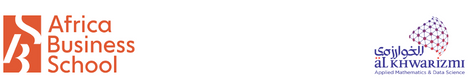

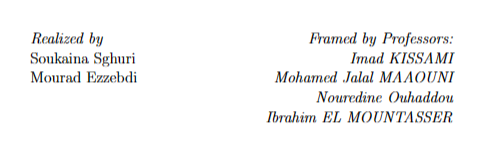

## Part 1

<b>The cell below is for imports. You are only allowed to use `numpy` for this part.No additional imports are allowed</b>

In [4]:
"""
import os
arch = os.getenv("ARGS", "real")

try: 
    import google.colab  # noqa: F401
except ImportError:
    import petsc4py
else:
    try:
        import petsc4py
    except ImportError:
        if arch != "complex":
            !wget "https://fem-on-colab.github.io/releases/petsc4py-install-real.sh" -O "/tmp/petsc4py-install.sh" && bash "/tmp/petsc4py-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/petsc4py-install-complex.sh" -O "/tmp/petsc4py-install.sh" && bash "/tmp/petsc4py-install.sh"
        import petsc4py
"""

'\nimport os\narch = os.getenv("ARGS", "real")\n\ntry: \n    import google.colab  # noqa: F401\nexcept ImportError:\n    import petsc4py\nelse:\n    try:\n        import petsc4py\n    except ImportError:\n        if arch != "complex":\n            !wget "https://fem-on-colab.github.io/releases/petsc4py-install-real.sh" -O "/tmp/petsc4py-install.sh" && bash "/tmp/petsc4py-install.sh"\n        else:\n            !wget "https://fem-on-colab.github.io/releases/petsc4py-install-complex.sh" -O "/tmp/petsc4py-install.sh" && bash "/tmp/petsc4py-install.sh"\n        import petsc4py\n'

This code imports the numpy library as "np" and the MPI library from "mpi4py" module. It then initializes the MPI communication world, retrieves the number of processes and the rank of the current process.

In [3]:
import numpy as np
from mpi4py import MPI

comm   = MPI.COMM_WORLD
nprocs = comm.Get_size()
rank   = comm.Get_rank()

Now, we will create our class `SparseMatrix`

The class will represent a sparse matrix in `COO` format.\
it should also keep track of the shape of the matrix.\
You need to add the necessary attributes to your class to account for the aforementioned requirements

Let's start with the `__init__` method of our class:\
it should take one additional argument `arg` that will represent the various objects from which we can instantiate our class.

First, we should be able to construct an instance of our class from a regular `numpy` 2d array. \
Inside the `__init__` method, check if `arg` is an instance of a `numpy` array. \
Then, check if the provided array represents a valid matrix.\
If it is not the case, an exception should be raised 
________________________________________________________________________________________________________________________________

The code begins by  defining a class called SparseMatrix. The class has an initialization method that expects a numpy array as an argument named 'arg'. The code then verifies if the input argument is a numpy array and whether it has a valid matrix shape (i.e., 2D). If any of these checks fail, the code raises an appropriate exception.

In [4]:
class SparseMatrix:
    def __init__(self, arg):
        if type(arg) is not np.ndarray:
            raise TypeError('The Input is not a Numpy array')
        if len(arg.shape) !=  2:
            raise ValueError("invalid Matrix")

Next, we should be able to construct an instance of our class from a tuple of 3 `numpy` arrays representing a matrix in `COO` format (x, Y, Values)\
Extend the __init__ method by checking if arg is an instance of this case.
Then, check if the provided array represents a valid matrix.
If it is not the case, an exception should be raised

------------------------------------------------------------------------------------------------------------------------------

The code introduces a class named SparseMatrixCOO that has an init method accepting a tuple containing three numpy arrays representing a matrix in COO format. It verifies the correctness of the input by ensuring that it is a tuple with exactly three numpy arrays. 

Additionally, it checks whether every element in the tuple is a numpy array. Moreover, it defines a method called print_coo that prints the three numpy arrays in COO format.

In [34]:
class SparseMatrix:
    def __init__(self, arg):
        self.row , self.col , self.data = arg

        if type(arg) is not tuple:
            raise TypeError("The input must be a tuple")
        if len(arg) != 3 :
            raise ValueError("Invalid COO format, the input tuple must contain 3 np.arrays (row,col,data)")
        i = 0
        while i+1 < len(arg):
            if len(arg[i]) != len(arg[i+1]):
                raise ValueError('The lists must have the same size')
            i +=1
        for lis in arg:
            if type(lis) is not np.ndarray:
                raise TypeError('The elements inside the input are not a Numpy arrays')

Create a function `cooTranspose` that takes an instance of our class `SparseMatrix` and returns its transpose.
______________________________________________________________________________________________________________________________
The cooTranspose function transposes a SparseMatrixCOO object by swapping its row and column indices. The function then returns the transposed object.

In [6]:
def cooTranspose(a):
    a.row , a.col = a.col , a.row
    return a

Create a function `cooMatVec` that takes an instance of our class `SparseMatrix` and a vector \ 
as a `numpy` array and returns their product.
_____________________________________________________________________________________________________________________________
The code defines a function called cooMatVec that takes an instance of the SparseMatrix class and a vector as a numpy array and returns their product.

In [7]:
def cooMatVec(A, x):
    if len(A.col) != len(x) :
        raise ValueError('Wrong shape input')

    vec = [0] * len(A.row) # Initialize vec to all zeros
    for i in range(len(A.data)):
        vec[A.row[i]] += A.data[i] * x[A.col[i]]
    return vec


Create a function cooMatMat that takes two instances of our class `SparseMatrix` and \ 
returns their matrix product as a 2 dimentional numpy array
_____________________________________________________________________________________________________________________________
The function cooMatMat takes two SparseMatrix instances as input and returns their product as a numpy array using a nested loop implementation of matrix multiplication. It verifies the shape compatibility of the input matrices before computing their product.

In [8]:
def CooMatMat(A, B):
    C =np.zeros((len(A.row),len(B.col)))

    #cheking if the input matrixes can be multiplied by verifying the compatibility of their shape
    if len(A.col) != len(B.row) :
        raise ValueError("Wrong shape input, the number of columns of first matrix is'nt matching number of rows of second matrix")
    data_a = A.data
    row_a = A.row
    col_a = A.col
    data_b = B.data
    row_b = B.row
    col_b = B.col

    for i, j, v in zip(row_a, col_a, data_a):
        for k, l, w in zip(row_b, col_b, data_b):
            if j == k:
                C[i, l] += v * w
    return C

# Part 2

In this part, we will be solving a system of linear equations involving a sparse matrix `A` in parallel. \
You will not have to solve the system. However, you will have to implement the function `CreateLocalMatVec` that sets the system for the class `LinearSystem`. \
At the end, compare the results and explain any discrepancies.

In [9]:
#Create the matrix and Rhs
np.random.seed(42)
from scipy.sparse import random
if rank == 0:
    n = 100
    # Set parameters for the sparse matrix
    density = 0.3 # density of non-zero elements (between 0 and 1)
    A =  random(n, n, density=density, format='csr')
    x = np.random.rand(n)
    B_all = np.dot(A.toarray(),x)
else:
    A = None
    B_all = None

In [10]:
def CreateLocalMatVec(A, B_all):
    if rank == 0:


        shape = A.shape
        nrows = shape[0]
        # split the number of rows evenly (as possible) among the MPI tasks
        N_pertask, extra = divmod(nrows, nprocs)

        # count: the size of each sub-task
        count = [N_pertask + 1 if i < extra else N_pertask for i in range(nprocs)]

        # displacement: the starting index of each sub-task
        displ = [sum(count[:i]) for i in range(nprocs)]

        #---- Send the relevant subsets of A and B to each slave MPI task ----
        for i in range(1,nprocs):

            # Get the start and end row index for this MPI task
            rstart =  displ[i]
            rend   = rstart + count[i]

            #---- Get the subsets of A and B using these rows ----
            A_indptr  = np.array(A.indptr[rstart:rend+1] - A.indptr[rstart])
            # modified row-pointer array that will be consistent on the MPI task
            pstart    = A.indptr[rstart]    # starting row-pointer index
            pend      = A.indptr[rend]   # end      row-pointer index

            A_indices = np.array(A.indices[pstart:pend])
            A_data    = np.array(A.data[pstart:pend])
            B         = np.array(B_all[rstart:rend])

            # Save the lengths of each array
            lengths = {
                    'A_indptr' : len(A_indptr),
                    'A_indices': len(A_indices),
                    'A_data'   : len(A_data),
                    'B'        : len(B)
                    }

            # Send the arrays and their lenghts to the relevant MPI task
            comm.send(lengths,dest=i)
            comm.Send(A_indptr,dest=i)
            comm.Send(A_indices,dest=i)
            comm.Send(A_data,dest=i)
            comm.Send(B,dest=i)

             #---- Set the relevant subsets of A and B for the master MPI task (we don't need to do an MPI Send)
        rstart = displ[0]
        rend   = rstart + count[0]

        A_indptr  = np.array(A.indptr[rstart:rend+1] - A.indptr[rstart])
        pstart    = A.indptr[rstart]
        pend      = A.indptr[rend]

        A_indices = np.array(A.indices[pstart:pend])
        A_data    = np.array(A.data[pstart:pend])
        B         = np.array(B_all[rstart:rend])
    else:
         # Receive the array lengths
        lengths   = comm.recv(source=0)
        # Initialise the buffers
        A_indptr  = np.empty(lengths['A_indptr'], dtype=np.int32)
        A_indices = np.empty(lengths['A_indices'], dtype=np.int32)
        A_data    = np.empty(lengths['A_data'], dtype=A.dtype)
        B         = np.empty(lengths['B'], dtype=B_all.dtype)
        # Receive the arrays
        comm.Recv(A_indptr,source=0)
        comm.Recv(A_indices,source=0)
        comm.Recv(A_data,source=0)
        comm.Recv(B,source=0)

        shape = None

    # broadcast shape
    shape = comm.bcast(shape, root=0)

    return (A_indptr, A_indices, A_data, B, shape)


In [11]:
class LinearSystem():
    def __init__(self, A=None, shape=None, rhs=None, solver=None, comm=None):
        
        from petsc4py import PETSc
        self.opts = PETSc.Options()

        self.ksp = PETSc.KSP()
        self.ksp.create()
        
        mat = PETSc.Mat().createAIJ(comm=comm, size=shape, csr=A)
        mat.setUp()
        mat.assemblyBegin()
        mat.assemblyEnd()
        self.sol, self.rhs = mat.getVecs()
        self.rhs.setArray(rhs)
        
        
        #---- Set up solver -----
        self.ksp = PETSc.KSP().create(comm=comm)
        
        # It is commonly used with the direct solver preconditioners like PCLU and PCCHOLESKY
        self.ksp.setType('preonly')
        pc = self.ksp.getPC()
        pc.setType('lu')
        pc.setFactorSolverType(solver)
        
        self.ksp.setOperators(mat)
        self.ksp.setFromOptions() # Apply any command line options
        self.ksp.setUp()
    
    def solve(self): 
        # st=timeit.default_timer()
        self.ksp.solve(self.rhs, self.sol)

In [12]:
(A_indptr, A_indices, A_data, b, shape) = CreateLocalMatVec(A, B_all)

L = LinearSystem(A=(A_indptr, A_indices, A_data), rhs=b, shape=shape, solver="mumps")
ts = MPI.Wtime()
L.solve()
te = MPI.Wtime()
tt = comm.reduce(te - ts, op=MPI.MAX, root=0)
if rank == 0:
    print("Timing to solve the linear system with petsc", tt)

Timing to solve the linear system with petsc 0.0009621679999999994


In [13]:
#---- Gather the solution onto a single array on the master MPI task
if rank == 0:
    X = np.empty(shape[0],dtype=np.double)
else:
    X = None
comm.Gatherv(L.sol.array,X)

In [35]:
np.random.seed(42)
if rank == 0:
    A_coo = A.tocoo()
    B = SparseMatrix((A_coo.row,A_coo.col,A_coo.data))
    
    from scipy import sparse
    from scipy.sparse.linalg import spsolve
    mat = sparse.csr_matrix((B.data, (B.row, B.col)))
    ts = MPI.Wtime()
    sol = spsolve(mat, b)
    te = MPI.Wtime()
    print("Timing to solve the linear system with spsolve", te - ts)

Timing to solve the linear system with spsolve 0.001159788999984812


In [36]:
if rank == 0:
    print(np.allclose(X,sol))

True
